# Executive Summary

Objective: determine if personalized marketing contents are more effective than control in subscribing users, and if so, what is their lift?

In this month-long campaign, two versions of marketing contents - control and personalized - were shown to users across Facebook, Instagram, email, push notification, and house ads. Across all channels, personalized contents were much more effective in subscribing users. Notably on Instagram and in push notification, it was 451% and 408%, respectively, more effective than the control. House ads, however, had a negative lift, meaning the control was more effective than the personalized contents. Further investigation showed that this was due to a bug that reset users’ displayed language, which no longer matched with their preferred language. Analysis showed that about 32 subscribers were lost due to this bug. It is recommended to present personalized marketing contents while ensuring displayed and preferred languages match to encourage users to subscribe.

# 1. Import and prepare data

In [24]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [25]:
dat = pd.read_csv("marketing1.csv")
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              10037 non-null  object
 1   date_served          10021 non-null  object
 2   marketing_channel    10022 non-null  object
 3   variant              10037 non-null  object
 4   converted            10022 non-null  object
 5   language_displayed   10037 non-null  object
 6   language_preferred   10037 non-null  object
 7   age_group            10037 non-null  object
 8   date_subscribed      1856 non-null   object
 9   date_canceled        577 non-null    object
 10  subscribing_channel  1856 non-null   object
 11  is_retained          1856 non-null   object
dtypes: object(12)
memory usage: 941.1+ KB


First, converting to appropriate datatypes

In [26]:
for i in ['marketing_channel', 'variant', 'language_displayed', 'language_preferred', 'age_group', 'subscribing_channel']:
    dat[i] = dat[i].astype("category")
for i in ['converted','is_retained']:
    dat[i] = dat[i].astype('bool') # converting 'converted', and 'is_retained' to boolean values
for i in ['date_served','date_subscribed','date_canceled']:
    dat[i] = pd.to_datetime(dat[i], format='%m/%d/%y') # converting the date variables to Datetime objects

### Are the number of control and the number of personalized similar to each other across all marketing channels?

Except for House Ads, the number of personalized is greater than the number of control for all marketing channels. Greater the difference, less accurate the analysis may be - Instagram and Push have the two highest difference.

In [27]:
for i in dat.marketing_channel.unique().dropna():
    n = dat.groupby(['marketing_channel','variant']).user_id.nunique()
    control_n = n[i][0]
    person_n = n[i][1]
    print(i + ": ")
    print("number of control is " + str(control_n) + "; number of personalized is " + str(person_n))
    print("There is a " + str(round(abs(control_n - person_n)/np.mean([control_n, person_n])*100, 2))
          + "% difference in the number of control and personalized \n")

House Ads: 
number of control is 2071; number of personalized is 1939
There is a 6.58% difference in the number of control and personalized 

Push: 
number of control is 462; number of personalized is 520
There is a 11.81% difference in the number of control and personalized 

Facebook: 
number of control is 846; number of personalized is 946
There is a 11.16% difference in the number of control and personalized 

Instagram: 
number of control is 835; number of personalized is 960
There is a 13.93% difference in the number of control and personalized 

Email: 
number of control is 270; number of personalized is 284
There is a 5.05% difference in the number of control and personalized 



# 2. Is B better than A?

### Visualizing the change in conversion rates throughout the campaign

How do conversion rates compare between control (blue line) and personalized (orange line) contents throughout the campaign? Conversion rates are graphed from the start to end of the campaign.

Comparing the rates for email is difficult since there is a lot fewer days when the control email was sent out. For Facebook, Instagram and Push, personalized contents show higher conversion rates. For House Ads, it is difficult to say one is better than the other since control resulted in much higher conversion rates at the beginning of the campaign, but becomes less effective towards the end.

In [28]:
personalized = dat[(dat.marketing_channel.notnull()) & (dat.variant == 'personalization')]
person_total = personalized.groupby(['date_served','marketing_channel'])['user_id'].nunique().unstack(1)
person_converted = personalized[personalized['converted']==True].groupby(['date_served','marketing_channel'])['user_id'].nunique().unstack(1)
person_cr = person_converted/person_total

control = dat[(dat.marketing_channel.notnull()) & (dat.variant == 'control')]
control_total = control.groupby(['date_served','marketing_channel'])['user_id'].nunique().unstack(1)
control_converted = control[control['converted']==True].groupby(['date_served','marketing_channel'])['user_id'].nunique().unstack(1)
control_cr = control_converted/control_total

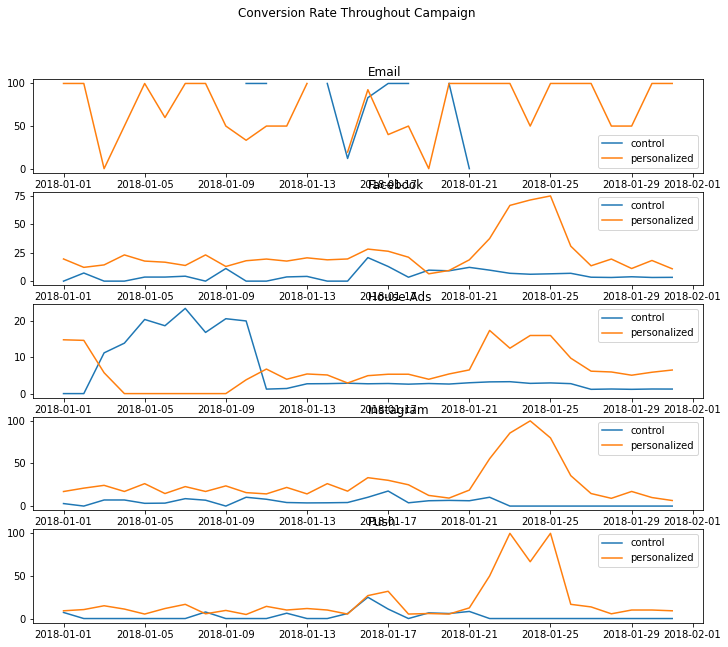

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 10))


for i in range(5):
    ax[i].plot(control_cr.iloc[:,i]*100, label="control")
    ax[i].plot(person_cr.iloc[:,i]*100, label="personalized")
    ax[i].set_title(list(person_converted.columns)[i], horizontalalignment='left', verticalalignment='top')
    ax[i].legend()
    
fig.suptitle("Conversion Rate Throughout Campaign")
plt.show()

It would be a good idea to create a function that calculates conversion rates. The function below returns a dataframe containing conversion rates for every categorical values in 'col_names' (a list of columns).

In [8]:
def conversion_rate(df, col_names):
    """Return a dataframe of conversion rates for every categorical values in col_names (a list of columns), given a df (a dataframe)."""
    # total number of converted users
    subscribed = df[df.converted == True].groupby(col_names)['user_id'].nunique()

    # total number users
    total = df.groupby(col_names)['user_id'].nunique()  
    
    # conversion rate 
    cr = subscribed/total
    
    # fill missing values with 0
    cr = cr.fillna(0)
    return cr

### Calculating the overall lift and testing if the difference in the conversion rates is statistically significant

Lift is the %increase in a metric due to an attributable change and is calculated by (challenger metric - control metric) / control metric. Here, the overall conversation rate for control and for challenger are calculated for each marketing channel. Then, the overall lift is calculated for each marketing channel. Push and Instagram have the two highest lift while House Ads has a negative lift. This means that personalized contents were very effective in subscribing users across all marketing channels, except House Ads. For example, personalized contents on Instagram resulted in a conversion rate that is 379.56% greater than that of the control. 

Two sample t-test determines if the difference between the control and challenger metrics is statistically significant. All p-values, except that of House Ads, are smaller than 0.005, meaning the differences between control and challenge are statistically significant with 95% confidence. Further investigation should be done on House Ads.

In [32]:
for i in dat.marketing_channel.unique()[:-1]:
#def lift(dat, i)
    cr = conversion_rate(dat[dat.marketing_channel == i], ['user_id','variant']).unstack(1)
    
    a_mean = np.mean(cr['control'])
    b_mean = np.mean(cr['personalization'])
    lift = (b_mean - a_mean)/a_mean
    
    print(i + ": ")
    print("overall conversion rate for control is", round(a_mean*100,2), "% and for personalized is ", round(b_mean*100,2), "%")
    print("lift is ", round(lift*100, 2), "%")
    print("significance test: ", stats.ttest_ind(cr['control'], cr['personalization']), "\n")

House Ads: 
overall conversion rate for control is 4.33 % and for personalized is  3.18 %
lift is  -26.74 %
significance test:  Ttest_indResult(statistic=2.7171144721315073, pvalue=0.0065996702529420885) 

Push: 
overall conversion rate for control is 1.34 % and for personalized is  6.79 %
lift is  407.69 %
significance test:  Ttest_indResult(statistic=-6.143664494905133, pvalue=9.756905311430725e-10) 

Facebook: 
overall conversion rate for control is 2.62 % and for personalized is  10.24 %
lift is  291.3 %
significance test:  Ttest_indResult(statistic=-9.325278871865464, pvalue=1.9022355062483612e-20) 

Instagram: 
overall conversion rate for control is 2.13 % and for personalized is  11.72 %
lift is  451.35 %
significance test:  Ttest_indResult(statistic=-11.351870211012246, pvalue=2.3697704003425617e-29) 

Email: 
overall conversion rate for control is 13.74 % and for personalized is  20.07 %
lift is  46.05 %
significance test:  Ttest_indResult(statistic=-2.8153178306644815, pvalue

# 3. Further investigation on House Ads

Conversion rates were higher for personalized contents across all marketing channels, except for House Ads. Further investigation can be done to understand why this happened. The dataframe is segmented to focus only on house ads.

In [10]:
house_ads = dat[dat.marketing_channel == 'House Ads']
house_ads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4733 entries, 0 to 9994
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              4733 non-null   object        
 1   date_served          4732 non-null   datetime64[ns]
 2   marketing_channel    4733 non-null   category      
 3   variant              4733 non-null   category      
 4   converted            4733 non-null   bool          
 5   language_displayed   4733 non-null   category      
 6   language_preferred   4733 non-null   category      
 7   age_group            4733 non-null   category      
 8   date_subscribed      760 non-null    datetime64[ns]
 9   date_canceled        258 non-null    datetime64[ns]
 10  subscribing_channel  760 non-null    category      
 11  is_retained          4733 non-null   bool          
dtypes: bool(2), category(6), datetime64[ns](3), object(1)
memory usage: 223.1+ KB


Plotting the overall conversion rate of House Ads, a dip (where the red vertical line is) can be observed on January 11th. Something occurred on this date that resulted in the sudden decrease of converion rates.

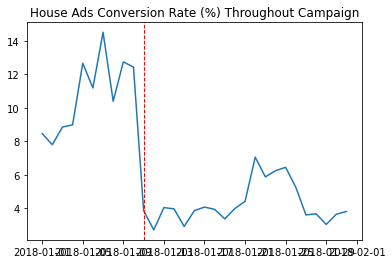

In [11]:
house_ads_conversion = conversion_rate(house_ads, ['date_served'])

plt.plot(house_ads_conversion*100)
plt.axvline(x = np.datetime64('2018-01-11'), color='red', linewidth = 1, linestyle ="--")
plt.title("House Ads Conversion Rate (%) Throughout Campaign")
plt.show()

The percentage of users whose displayed language matches with their preferred language throughout the campaign is plotted on a graph. Almost all of the users' languages matched before the 11th, but the percentages drop to almost half afterwards. This pattern coincides with the drop in the House Ads' conversion rate on the 11th. There may have been a bug that reset the displayed language, resulting in the incorrectly set displayed language and causing inconvenience to the users. This bug probably have caused the drop in the conversion rates.

<ipython-input-12-62811bc43bce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_ads['matching_lang'] = np.where(house_ads['language_displayed'] == house_ads['language_preferred'], 'Yes', 'No')


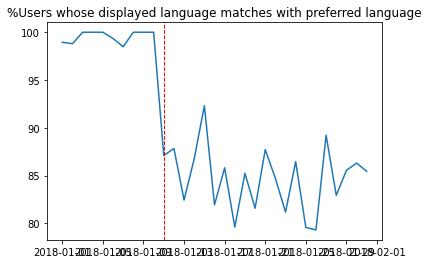

In [12]:
# creating a new column where the value is 'Yes', if the displayed languaged matches with the preferred language,
# and 'No', if they do not match
house_ads['matching_lang'] = np.where(house_ads['language_displayed'] == house_ads['language_preferred'], 'Yes', 'No')
language_df = house_ads.groupby(['date_served','matching_lang'])['matching_lang'].count().unstack(1).fillna(0)

plt.plot(language_df.index.values, language_df['Yes']/language_df.sum(1)*100, label="languages match")
plt.axvline(x = np.datetime64('2018-01-11'), color='red', linewidth = 1, linestyle ="--")
plt.title("%Users whose displayed language matches with preferred language")
plt.show()

Plotting the conversion rates for each displayed language, it can be observed that only the English language converted users consistently after the 11th, meaning the bug mostly affected the non-English language users.

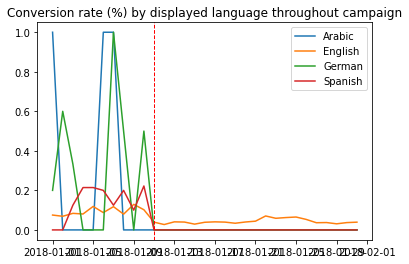

In [13]:
language_daily = conversion_rate(house_ads, ['date_served','language_displayed']).unstack(1)

for i in language_daily:
    plt.plot(language_daily[i], label=i)
plt.legend()
plt.axvline(x = np.datetime64('2018-01-11'), color='red', linewidth = 1, linestyle ="--")
plt.title("Conversion rate (%) by displayed language throughout campaign")
plt.show()

### How many potential subscribers were lost?

Expected number of subscribed users can be estimated by multiplying the expected conversion rate with the total number of users of that language divided by 100. For example, to estimate what could have been $\hat{S}_{Spanish}$, the number of subscribed Spanish-language users if it wasn't for the bug, 

$$C = \text{conversion rate;  } S = \text{number of subscribed users;  } T = \text{total number of users}$$

$$
\hat{\text{C}}_{Spanish} = \frac{\hat{S}_{Spanish}}{T_{Spanish, bug}} \cdot 100
$$

$$
where, \hat{\text{C}}_{Spanish} = \frac{\text{C}_{Spanish, pre-bug}}{\text{C}_{English, pre-bug}} \cdot S_{English, bug}
$$

$$
\Rightarrow \frac{\text{C}_{Spanish, pre-bug}}{\text{C}_{English, pre-bug}} \cdot S_{English, bug} = \frac{\hat{S}_{Spanish}}{T_{Spanish, bug}} \cdot 100
$$

$$
\Rightarrow \hat{S}_{Spanish} = \frac{\text{C}_{Spanish, pre-bug}}{\text{C}_{English, pre-bug}} \cdot S_{English, bug} \cdot \frac{T_{Spanish, bug}}{100}
$$

To estimate the total number of potential subscribers lost due to the bug, the expected total number of subscribers of non-English languages (since it was the non-English languages that were affected) should be subtracted by the actual number of subscribers of non-English users during the time affected by the bug.

$$
\text{Total number of subscribers lost} = \hat{S}_{Spanish} + \hat{S}_{Arabic} + \hat{S}_{German} - (S_{Spanish, bug} + S_{Arabic, bug} + S_{German, bug})
$$


Examining the time period before Jan 11th, it is found that Arabic as displayed language had the highest conversion rate of 0.50 while English had the lowest rate of 0.10. 

In [14]:
pre_bugged = house_ads[house_ads.date_served < '2018-01-11']
pre_bugged_language_cr = conversion_rate(pre_bugged, ['language_displayed'])
pre_bugged_language_cr

language_displayed
Arabic     0.500000
English    0.099093
German     0.444444
Spanish    0.166667
Name: user_id, dtype: float64

Non-English language conversion rates can be indexed against the English conversion rate to determine how well non-English users converted relative to English users prior to the bug. This gives us, $$ \frac{\text{C}_{language, pre-bug}}{\text{C}_{English, pre-bug}} $$

Before the bug, Spanish users converted at around 1.7 times the English users, Arabic users converted 5.05 times the English users, and German users converted at around 4.49 times the English users.

In [15]:
spanish_index = pre_bugged_language_cr['Spanish']/pre_bugged_language_cr['English'] 
arabic_index = pre_bugged_language_cr['Arabic']/pre_bugged_language_cr['English']
german_index = pre_bugged_language_cr['German']/pre_bugged_language_cr['English']

print("spanish index: " + str(spanish_index))
print("arabic index: " + str(arabic_index))
print("german index: " + str(german_index))

spanish index: 1.681924882629108
arabic index: 5.045774647887324
german index: 4.485133020344287


Using the language index, daily converting rate relative to the English language can be estimated for each non-English language after the bug. The relative converting rate of a given language is estimated by multiplying the given language index with the number of English subscribers. This gives us, 
$$
\frac{\text{C}_{language, pre-bug}}{\text{C}_{English, pre-bug}} \cdot S_{English, bug}
$$

The relative converting rate is stored in the dataframe, 'expected_relative_rate '. Inspecting 'expected_relative_rate ', on Jan. 11th, Spanish users should have converted 10.1 times the English users and Arabic users should have converted 30.3 times the English users.

In [16]:
# dataframe containing the daily total number of unique users who saw the House Ads
# and the daily number of unique users who saw the ad and subscribed
language_conversion = house_ads.groupby(['date_served','language_preferred']).agg({'user_id':'nunique','converted':'sum'}).unstack(1)
language_conversion_bugged = language_conversion.loc['2018-01-11':'2018-01-31']['converted']

expected_relative_rate = pd.DataFrame(index = language_conversion_bugged.index)
# expected converting rate of Spanish users relative to English users
expected_relative_rate ['spanish'] = spanish_index * language_conversion_bugged['English']
# expected converting rate of Arabic users relative to English users
expected_relative_rate ['arabic'] = arabic_index * language_conversion_bugged['English']
# expected converting rate of German users relative to English users
expected_relative_rate ['german'] = german_index * language_conversion_bugged['English']

expected_relative_rate.head(3)

,spanish,arabic,german
date_served,,,
2018-01-11,10.091549,30.274648,26.910798
2018-01-12,5.045775,15.137324,13.455399
2018-01-13,8.409624,25.228873,22.425665


Finally, to estimate the expected number of subscribers for each language, we compute,

$$
\hat{S}_{language} = \frac{\text{C}_{language, pre-bug}}{\text{C}_{English, pre-bug}} \cdot S_{English, bug} \cdot \frac{T_{language, bug}}{100}
$$

The estimated numbers of subscribers are stored in the dataframe, 'expected_subscribers'. Inspecting 'expected_subscribers', on Jan. 11th, 1.3 Spanish users, 2.12 Arabic users, and 0.54 German users would have converted if not for the bug.

In [21]:
expected_subscribers = pd.DataFrame(index = language_conversion_bugged.index)
expected_subscribers['spanish'] = expected_relative_rate['spanish'] * language_conversion['user_id']['Spanish'] / 100
expected_subscribers['arabic'] = expected_relative_rate['arabic'] * language_conversion['user_id']['Arabic'] / 100
expected_subscribers['german'] = expected_relative_rate['german'] * language_conversion['user_id']['German'] / 100

expected_subscribers.head(3)

,spanish,arabic,german
date_served,,,
2018-01-11,1.311901,2.119225,0.538216
2018-01-12,0.555035,0.454120,0.538216
2018-01-13,1.345540,1.513732,1.121283


Lastly, to estimate the total number of potential subscribers lost, we add all the expected numbers of non-English subscribers and substract it by the actual number of non-English subscribers during the bug.

About 32 users may have subscribed if the bug did not reset users' displayed language.

In [22]:
expected = expected_subscribers['spanish'].sum() + expected_subscribers['arabic'].sum() + expected_subscribers['german'].sum()
actual = language_conversion_bugged.Spanish.sum() + language_conversion_bugged.Arabic.sum() + language_conversion_bugged.German.sum()

print("The number of potential subscribers lost: " + str(expected - actual))

The number of potential subscribers lost: 32.144143192488265


# 4. Conclusion

Across all marketing channels, personalized contents were much more effective in subscribing users. Notably on Instagram and in push notification, it was 451% and 408%, respectively, more effective than the control. The two sample t-test showed that the difference in the conversion rates between the control and personalized is indeed statistically significant. House ads, however, had a negative lift, meaning the control was more effective than the personalized contents. This was due to a bug that reset users’ displayed language, which no longer matched with their preferred language. Although only 32 subscribers were lost due to this bug, non-Enlgish language users had much higher subscription rates than the English language users, indicating the importance of further studying and targeting non-English users to drive growth.

It is recommended to personalize marketing contents while ensuring displayed and preferred languages match to encourage users to subscribe. It is also recommended to investigate what caused the bug and prevent such problems reoccurring in the future. As a next step, another A/B testing can be done within the personalized contents to further improve subscription rates. 